In [1]:
#!/usr/bin/python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from helper import predict_from_score, correlate, crt_plot, plt_precision_recall_vs_threshold, plt_precision_vs_recall, plot_roc_curve 
import sys
import pickle
sys.path.append("../tools/")

from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, precision_score, roc_curve, roc_auc_score

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

IMAGES = '../images/'
DATA   = '../data/'

----

In [2]:
#############################
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# features_list = ['poi','salary'] # You will need to use more features
payment_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'other', 'expenses', 'director_fees', 'total_payments']
stock_features   = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
mail_features    = ['from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']
extra_features   = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate',
                    'toPOI_rate', 'fromPOI_rate']
extra_finance    = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate']
extra_mail       = ['toPOI_rate', 'fromPOI_rate']
feature_list = payment_features + stock_features + mail_features + extra_features

In [3]:
### Load the dictionary containing the dataset
my_data = pd.read_pickle(DATA+"my_dataFrame.pkl")

In [4]:
my_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
poi,144.0,1.250000e-01,3.318733e-01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
salary,94.0,2.840875e+05,1.771311e+05,4.770000e+02,211802.000000,2.587410e+05,3.086065e+05,1.111258e+06
bonus,81.0,1.201773e+06,1.441679e+06,7.000000e+04,425000.000000,7.500000e+05,1.200000e+06,8.000000e+06
long_term_incentive,65.0,7.464912e+05,8.629174e+05,6.922300e+04,275000.000000,4.221580e+05,8.318090e+05,5.145434e+06
deferred_income,49.0,-5.712835e+05,9.347149e+05,-3.504386e+06,-583325.000000,-1.440620e+05,-3.834600e+04,-8.330000e+02
deferral_payments,37.0,8.671188e+05,1.297344e+06,7.961000e+03,85430.000000,2.274490e+05,8.753070e+05,6.426990e+06
other,90.0,4.700610e+05,1.404768e+06,2.000000e+00,1197.000000,3.857000e+04,3.440270e+05,1.035973e+07
expenses,96.0,5.453331e+04,4.671275e+04,1.480000e+02,22140.500000,4.654750e+04,7.925225e+04,2.287630e+05
director_fees,15.0,9.323447e+04,3.332008e+04,1.750000e+04,100017.000000,1.037500e+05,1.108950e+05,1.250340e+05
total_payments,123.0,2.516459e+06,9.455875e+06,1.480000e+02,377387.500000,1.099100e+06,2.064694e+06,1.035598e+08


----

In [5]:
### Extract features and labels from dataset for local testing
# data = featureFormat(my_dataset, features_list, sort_keys = True)
# labels, features = targetFeatureSplit(data)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Divide data into features and labels 
y = my_data['poi'].copy().astype(np.uint8)
X = my_data[feature_list].copy()

In [8]:
# Split data into training and test set using stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=77, stratify=y) 

In [9]:
# I spare 25% of the data as test set to have at least 5 'poi's in the test set. It's important to me to realize a high recall value, identifying as many 'poi's as possible.  
print "Number of POIs in the test set:" , y_test.sum()

Number of POIs in the test set: 6


In [10]:
# Save the order of insiders
insiders_train = y_train.index
insiders_test  = y_test.index

In [11]:
# Dealing with missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [12]:
# I'd like to explore different strategies filling NAN values
# Imputer_01:
# Applies median to mail and extra NAN features and 0 to financial NAN features
impute_01 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='median'), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')
# Imputer_02:
# Applies median to all NAN features 
impute_02 = SimpleImputer(strategy='median')
# Imputer_03:
# Applies 0.0 to all NAN features
impute_03 = SimpleImputer(strategy='constant', fill_value=0.0)
# Imputer 04
# Applies 0.0 to financial and extra_finance featurtes and median to 'mail_features' and 'extra_mail'
impute_04 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')
# Imputer 05
# Applies mean values to all NAN
impute_05 = SimpleImputer(strategy='mean')
imputers = [impute_01, impute_02, impute_03, impute_04, impute_05]

In [13]:
# Define different scaling strategies
no_scl     = FunctionTransformer(func=lambda x: x)
robust_scl = RobustScaler()
std_scl    = StandardScaler()
power_scl  = PowerTransformer(method='yeo-johnson')
scalers = [no_scl, robust_scl, std_scl, power_scl]
scaler_names = ['NO SCALING', 'ROBUST SCALER', 'STANDARD SCALER', 'POWER SCALER']

In [14]:
# XXX_train = impute.fit_transform(X_train)
# XXX_train_df = pd.DataFrame(XXX_train, columns=feature_list, index=insiders_train )
# XXX_train_df.head().transpose()

'''
def impute_data(X):
    imp_Zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0)
    imp_Median = SimpleImputer(missing_values=np.nan, strategy='median')
    
    finance_data = imp_Zero.fit_transform(X[:,:13])
    mail_data    = imp_Median.fit_transform(X[:,13:16])
    extra_data   = imp_Median.fit_transform(X[:,16:])
    
    return np.concatenate((finance_data, mail_data, extra_data), axis=1) 

impute_01 = FunctionTransformer(impute_data, validate=False)
'''

In [15]:
pipe_01 = Pipeline([ ('impute', impute_01), ('scale', RobustScaler()) ])
pipe_02 = Pipeline([ ('impute', impute_01), ('scale', StandardScaler()) ])

In [16]:
pipe_01.fit(X_train)

Pipeline(memory=None,
     steps=[('impute', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('finance_data', SimpleImputer(copy=True, fill_value=0.0, missing_values=nan,
       strategy='constant', verbose=0), ['salary', 'bonus', 'long_te...obustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True))])

In [17]:
X_train_scale_01 = pipe_01.transform(X_train)

In [18]:
X_train_scale_01_df = pd.DataFrame(X_train_scale_01, columns=feature_list, index=insiders_train)

In [19]:
X_train_scale_01_df.head().transpose()

,KOENIG MARK E,DETMERING TIMOTHY J,LEWIS RICHARD,REYNOLDS LAWRENCE,CORDES WILLIAM R
salary,0.368417,-0.000356,-0.780947,-0.497639,-0.780947
bonus,0.500000,0.176471,-0.323529,-0.205882,-0.323529
long_term_incentive,0.718938,0.996105,0.000000,0.374447,0.000000
deferred_income,0.000000,-9.541428,0.000000,-2.461538,0.000000
deferral_payments,0.000000,43.029545,0.000000,2.525071,0.000000
other,1.848136,0.001799,-0.011862,2.485953,-0.011862
expenses,1.931812,0.579950,-0.364935,-0.212882,-0.364935
director_fees,0.000000,0.000000,0.000000,0.000000,0.000000
total_payments,0.384526,0.167730,-0.514410,-0.291024,-0.514410
exercised_stock_options,0.042933,0.815196,0.144719,2.029747,0.031609


In [20]:
X_train_scale_01_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
salary,100.0,-0.085934,0.731335,-7.809469e-01,-0.780947,0.0,0.219053,3.339898
bonus,100.0,0.507704,1.564045,-3.235294e-01,-0.323529,0.0,0.676471,9.088235
long_term_incentive,100.0,0.957554,1.887966,0.000000e+00,0.000000,0.0,1.000000,12.330824
deferred_income,100.0,-2.557586,7.465183,-4.313090e+01,-1.000000,0.0,0.000000,0.000000
deferral_payments,100.0,9.324946,26.429992,0.000000e+00,0.000000,0.0,1.000000,145.733261
other,100.0,3.402819,13.948222,-1.186157e-02,-0.011862,0.0,0.988138,128.057577
expenses,100.0,0.282671,0.824878,-3.649350e-01,-0.364935,0.0,0.635065,3.771604
director_fees,100.0,11413.950000,33464.256641,0.000000e+00,0.000000,0.0,0.000000,125034.000000
total_payments,100.0,0.852677,5.881210,-5.144102e-01,-0.464876,0.0,0.535124,58.130180
exercised_stock_options,100.0,0.961774,3.140834,-3.395949e-01,-0.339595,0.0,0.660405,19.220484


In [21]:
from helper import crt_plot

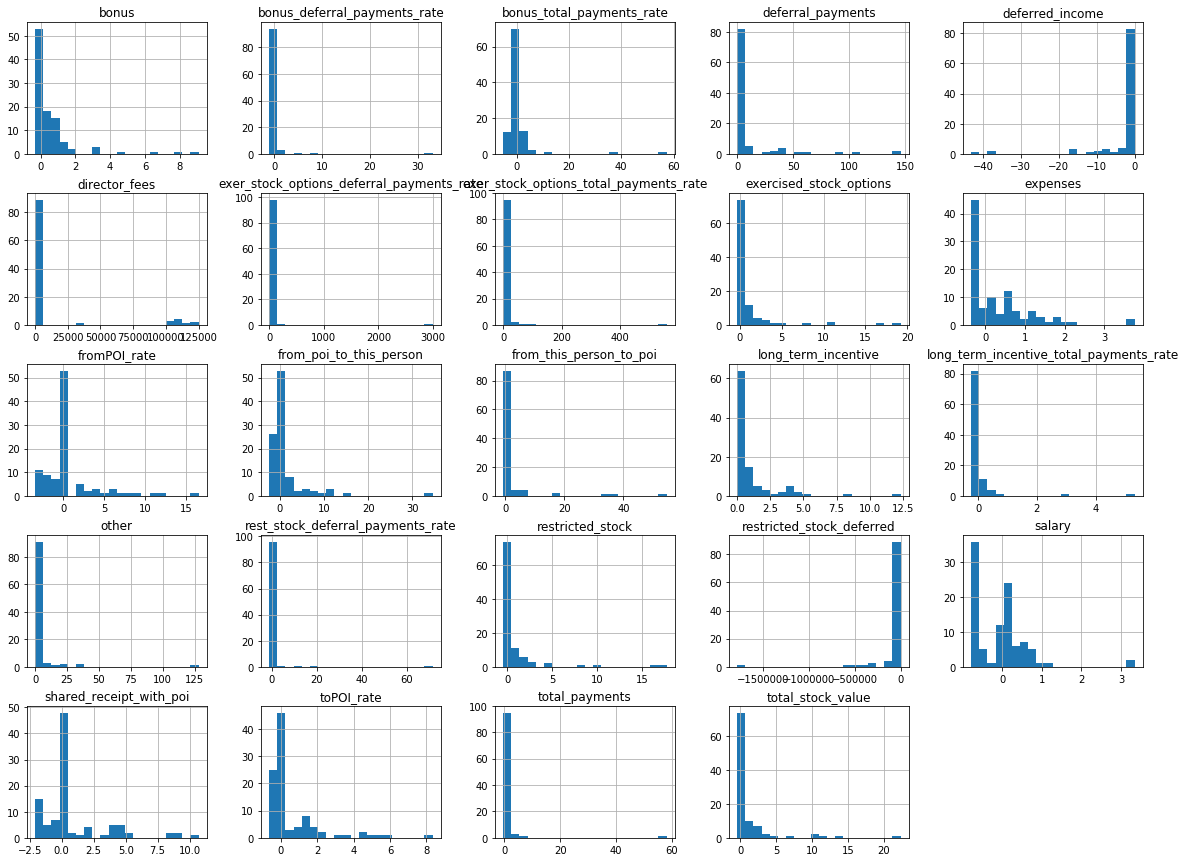

In [22]:
X_train_scale_01_df.hist(bins=20, figsize=(20,15));

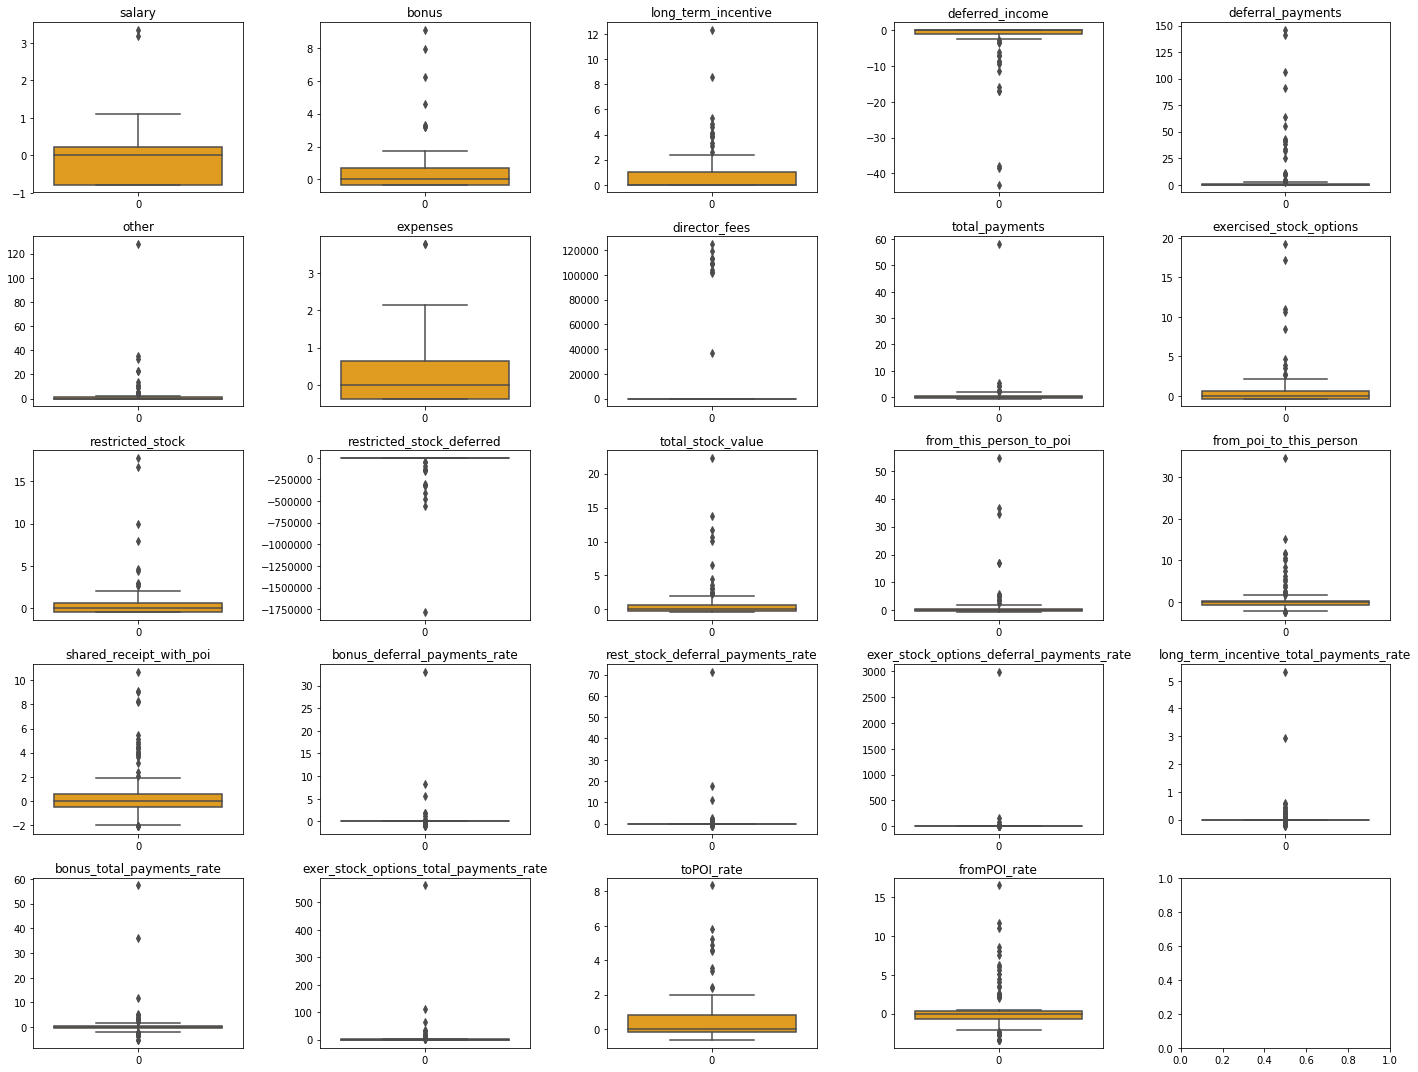

In [23]:
crt_plot(X_train_scale_01_df, feature_list, shape=(5,5), bins=20, sort=False)

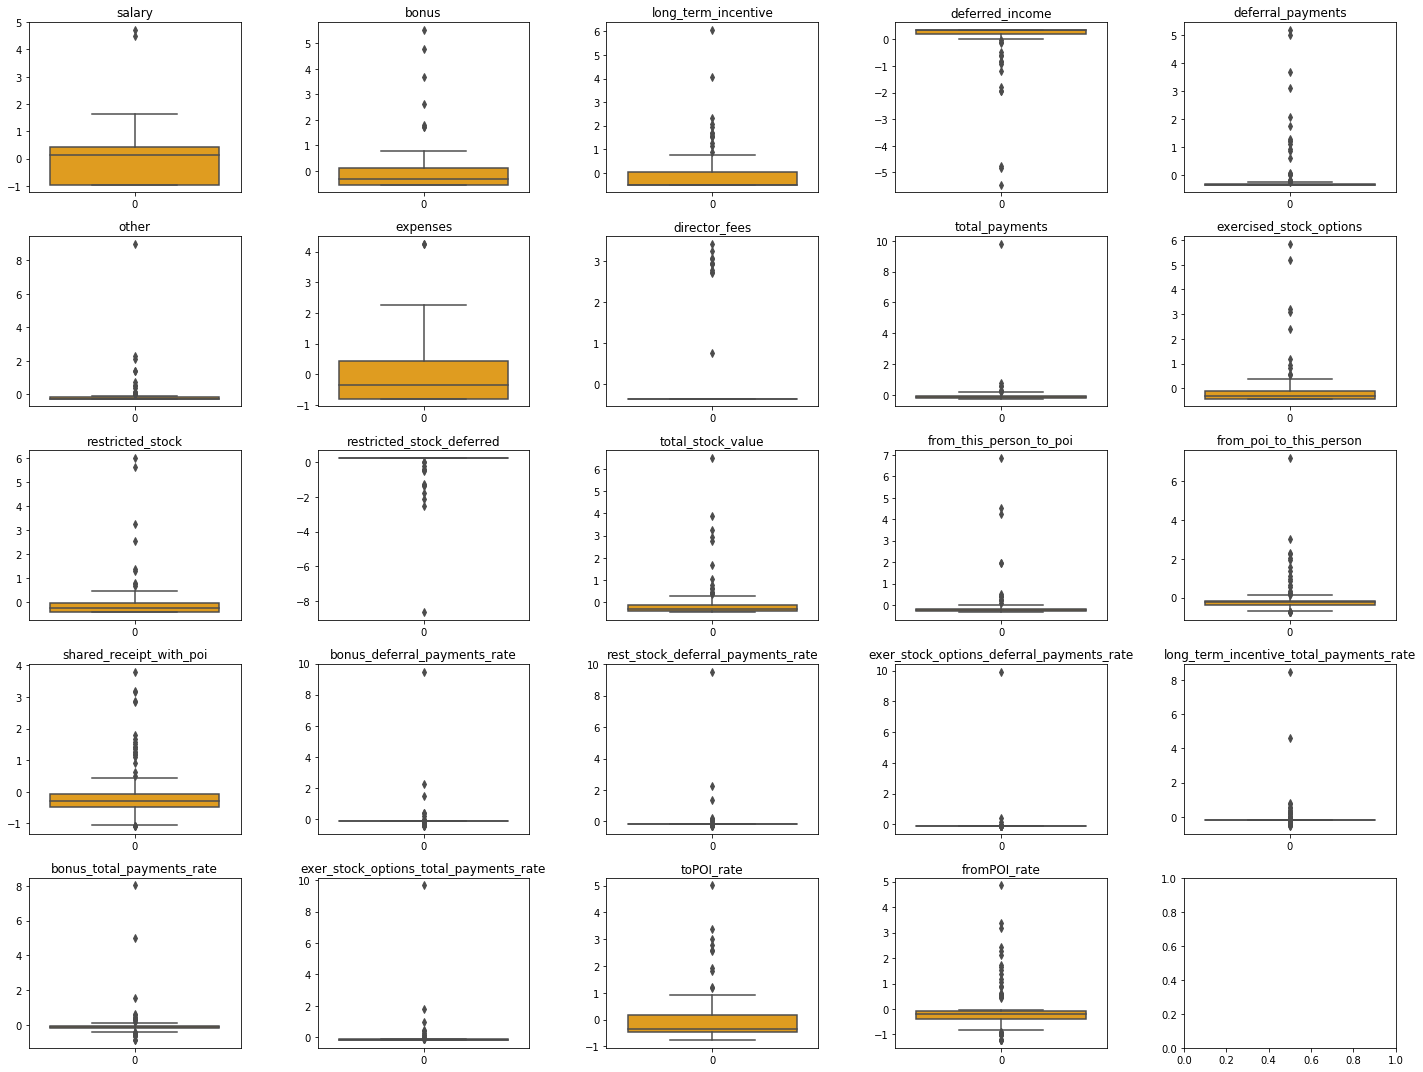

In [24]:
pipe_02.fit(X_train)
X_train_scale_02 = pipe_02.transform(X_train)
X_train_scale_02_df = pd.DataFrame(X_train_scale_02, columns=feature_list, index=insiders_train)
crt_plot(X_train_scale_02_df, feature_list, shape=(5,5), bins=20, sort=False)

In [25]:
X_train_scale_02_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
salary,100.0,-9.992007e-18,1.005038,-0.955123,-0.955123,0.118094,0.419128,4.707952
bonus,100.0,1.332268e-17,1.005038,-0.534142,-0.534142,-0.326245,0.108447,5.513754
long_term_incentive,100.0,4.551914e-17,1.005038,-0.509743,-0.509743,-0.509743,0.022596,6.054433
deferred_income,100.0,-2.386980e-17,1.005038,-5.462387,0.209698,0.344328,0.344328,0.344328
deferral_payments,100.0,-3.663736e-17,1.005038,-0.354594,-0.354594,-0.354594,-0.316568,5.187119
other,100.0,2.581269e-17,1.005038,-0.246045,-0.246045,-0.245190,-0.173990,8.981987
expenses,100.0,-3.191891e-17,1.005038,-0.789049,-0.789049,-0.344409,0.429359,4.250945
director_fees,100.0,8.881784e-18,1.005038,-0.342797,-0.342797,-0.342797,-0.342797,3.412371
total_payments,100.0,1.165734e-17,1.005038,-0.233621,-0.225156,-0.145714,-0.054267,9.788131
exercised_stock_options,100.0,9.992007e-18,1.005038,-0.416426,-0.416426,-0.307759,-0.096435,5.842618


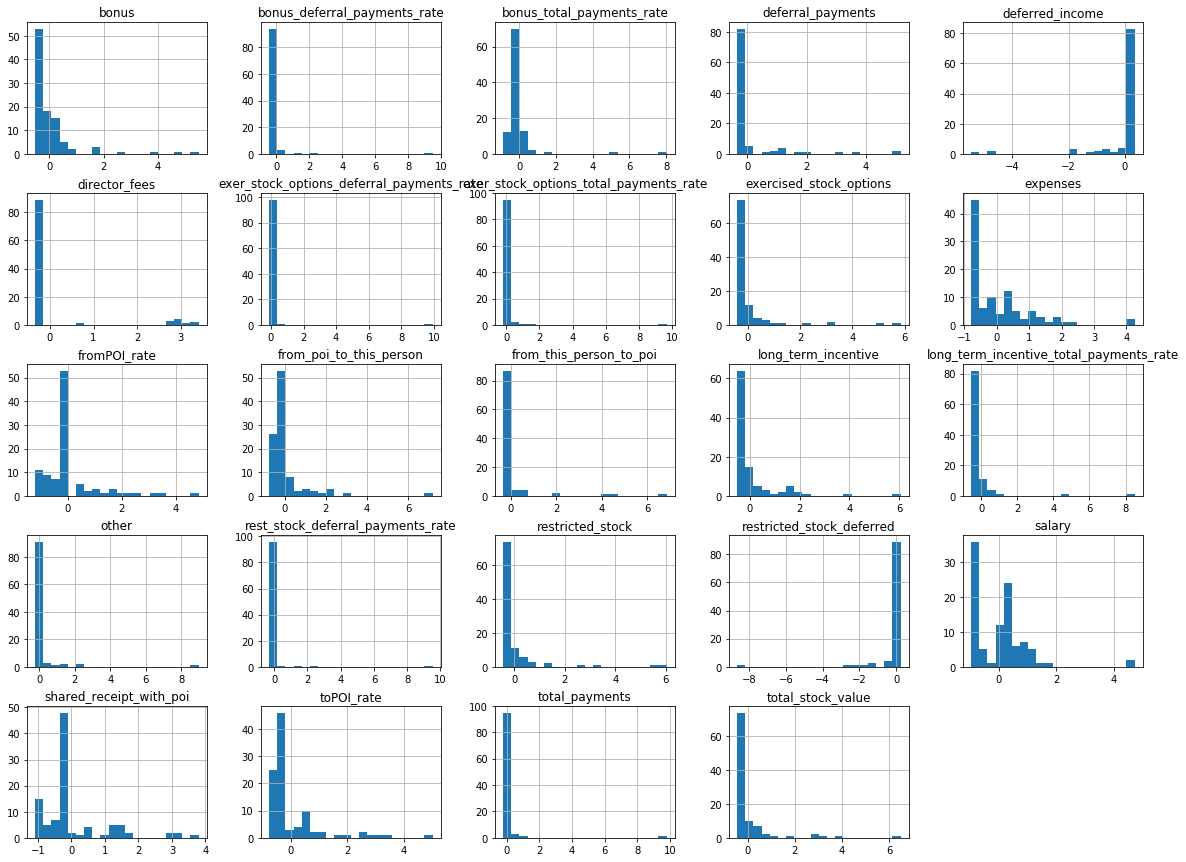

In [26]:
X_train_scale_02_df.hist(bins=20, figsize=(20,15));

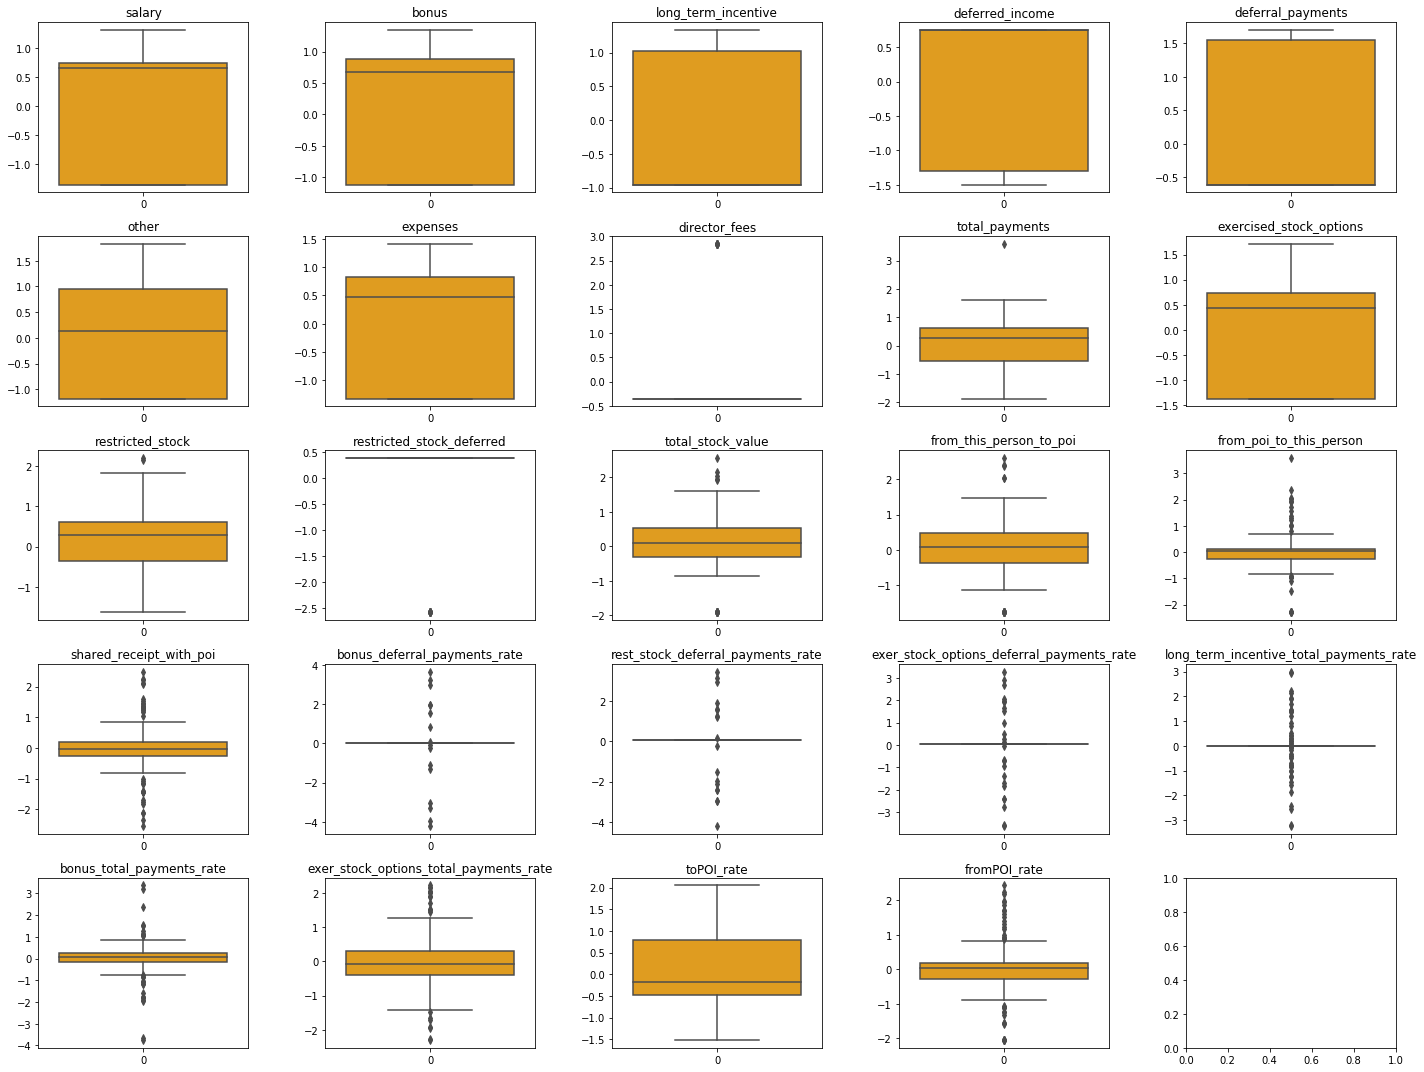

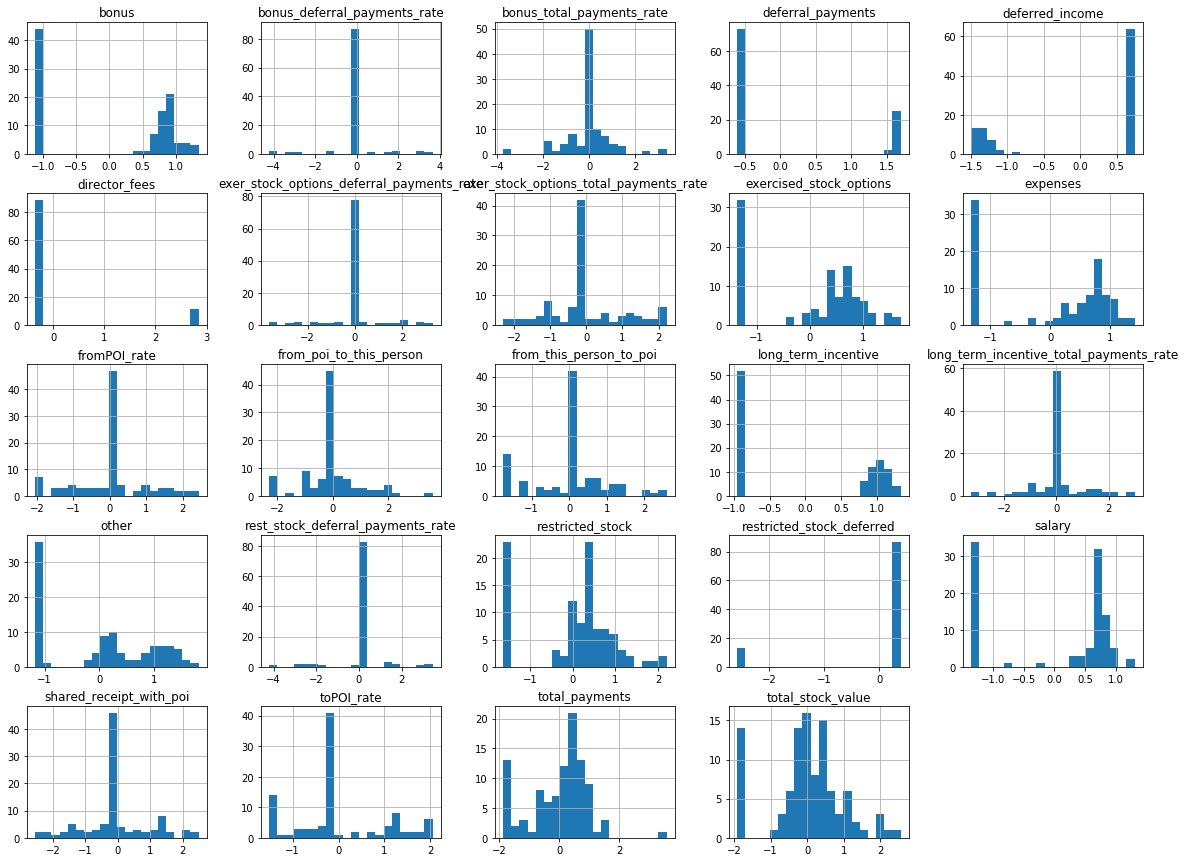

In [27]:
# Non-linear scaling with 'PowerTransformer'
pipe_03 = Pipeline([ ('impute', impute_01), ('scale', PowerTransformer(method='yeo-johnson')) ])
pipe_03.fit(X_train)
X_train_scale_03 = pipe_03.transform(X_train)
X_train_scale_03_df = pd.DataFrame(X_train_scale_03, columns=feature_list, index=insiders_train)
crt_plot(X_train_scale_03_df, feature_list, shape=(5,5), bins=20, sort=False)
X_train_scale_03_df.hist(bins=20, figsize=(20,15));

In [28]:
X_train_scale_03_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
salary,100.0,1.154632e-16,1.005038,-1.356942,-1.356942,0.658487,0.745639,1.308064
bonus,100.0,1.487699e-16,1.005038,-1.118002,-1.118002,0.673000,0.887096,1.342650
long_term_incentive,100.0,-1.676437e-16,1.005038,-0.956716,-0.956716,-0.956716,1.016184,1.332105
deferred_income,100.0,1.332268e-17,1.005038,-1.497219,-1.298414,0.747798,0.747798,0.747798
deferral_payments,100.0,-1.043610e-16,1.005038,-0.607979,-0.607979,-0.607979,1.542881,1.696778
other,100.0,5.107026e-17,1.005038,-1.178753,-1.178753,0.138894,0.956705,1.825532
expenses,100.0,1.199041e-16,1.005038,-1.321315,-1.321315,0.476702,0.827810,1.407588
director_fees,100.0,-2.220446e-17,1.005038,-0.351562,-0.351562,-0.351562,-0.351562,2.844527
total_payments,100.0,-1.287859e-16,1.005038,-1.869430,-0.545791,0.278574,0.610278,3.590123
exercised_stock_options,100.0,5.551115e-17,1.005038,-1.367328,-1.367328,0.443983,0.731193,1.711084


----

In [29]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

In [30]:
# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
NB_clf = GaussianNB()

In [31]:
from sklearn.linear_model import SGDClassifier  

In [32]:
SGD_clf = SGDClassifier(random_state=77)

In [33]:
from sklearn import svm

In [34]:
svm_clf = svm.SVC(gamma='auto')

In [35]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

In [36]:
KN_clf = KNeighborsClassifier(weights='distance', n_neighbors=3)

In [37]:
# Due to outlyers not good
# RN_clf = RadiusNeighborsClassifier(weights='uniform', radius=1000000)

In [38]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

In [39]:
RF_clf = RandomForestClassifier(random_state=77, n_estimators=100, bootstrap=True)

In [40]:
AB_clf = AdaBoostClassifier(n_estimators=50, random_state=77)

In [41]:
AB_svm_clf = AdaBoostClassifier(base_estimator=svm_clf, n_estimators=50, random_state=77, algorithm='SAMME')

In [42]:
AB_NB_clf = AdaBoostClassifier(base_estimator=NB_clf, n_estimators=50, random_state=77, algorithm='SAMME.R')

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
DT_clf = DecisionTreeClassifier(random_state=77, max_features='auto')

In [45]:
bag_clf = BaggingClassifier(KNeighborsClassifier(), max_samples=0.8, max_features=0.6, n_estimators=100, random_state=77)

In [46]:
classifiers = [ NB_clf, svm_clf, RF_clf, DT_clf, SGD_clf, KN_clf, AB_clf, AB_svm_clf, AB_NB_clf, bag_clf]

In [47]:
clf_names = [ 'Naive Bayes', 'SVC', 'Rand. Forest', 'Decision Tree', 'SGD', 'Near. Neighbor', 'AdaB-Tree', 'AdaB-svm', 'AdaB-NB', 'Bagging-KNeigh']

In [48]:
X_train_imp01 = impute_01.transform(X_train)

In [49]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

In [50]:
data = [ X_train_imp01, X_train_scale_01, X_train_scale_02, X_train_scale_03 ]
decision_functions = (type(SGD_clf), type(svm_clf), type(AB_NB_clf))
X = []
for clf in classifiers:
    print
    print clf
    for X, name in zip(data, scaler_names):
        accuracy = cross_val_score(clf, X, y_train, cv=10 )
        # Destinguish between pediction probability and decision function
        if not isinstance(clf, decision_functions):
            scores = cross_val_predict(clf, X, y_train, cv=10, method='predict_proba')
            auc = roc_auc_score(y_train, scores[:,1])
        else:
            scores = cross_val_predict(clf, X, y_train, cv=10, method='decision_function')
            auc = roc_auc_score(y_train, scores)
        print "Scaling:", name
        print "Roc AuC:", auc
        print "Accuray:", accuracy.mean()


GaussianNB(priors=None, var_smoothing=1e-09)
Scaling: NO SCALING
Roc AuC: 0.8314393939393939
Accuray: 0.8134343434343435
Scaling: ROBUST SCALER
Roc AuC: 0.6884469696969697
Accuray: 0.4195959595959596
Scaling: STANDARD SCALER
Roc AuC: 0.6543560606060607
Accuray: 0.7732323232323234
Scaling: POWER SCALER
Roc AuC: 0.777935606060606
Accuray: 0.6165656565656567

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Scaling: NO SCALING
Roc AuC: 0.4299242424242424
Accuray: 0.8814141414141415
Scaling: ROBUST SCALER
Roc AuC: 0.6254734848484849
Accuray: 0.8814141414141415
Scaling: STANDARD SCALER
Roc AuC: 0.7973484848484849
Accuray: 0.8814141414141415
Scaling: POWER SCALER
Roc AuC: 0.8986742424242424
Accuray: 0.8814141414141415

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=No

C:\Users\micha\Programs\anaconda3\envs\py27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Scaling: POWER SCALER
Roc AuC: 0.909090909090909
Accuray: 0.8584848484848484

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')
Scaling: NO SCALING
Roc AuC: 0.7007575757575758
Accuray: 0.9227272727272726
Scaling: ROBUST SCALER
Roc AuC: 0.6893939393939394
Accuray: 0.8823232323232324
Scaling: STANDARD SCALER
Roc AuC: 0.6051136363636364
Accuray: 0.8725252525252525
Scaling: POWER SCALER
Roc AuC: 0.8006628787878787
Accuray: 0.9107070707070708

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=77)
Scaling: NO SCALING
Roc AuC: 0.7954545454545454
Accuray: 0.8614141414141414
Scaling: ROBUST SCALER
Roc AuC: 0.793560606060606
Accuray: 0.8614141414141414
Scaling: STANDARD SCALER
Roc AuC: 0.8001893939393939
Accuray: 0.8614141414141414
Scaling: POWER SCALER
Roc AuC: 0.7982954545454545
Accuray: 0.8614141414141414

A

In [51]:
# Calculate the ROC AUC for all preselected classifiers
# Investigate impact of imputing
classifiers = [KN_clf, svm_clf, SGD_clf, NB_clf, AB_NB_clf, RF_clf]
decision_functions = (type(SGD_clf), type(svm_clf))
for clf in classifiers:
    print "\n", clf
    for imp, imp_name in zip(imputers, range(1, len(imputers)+1)):
            for scl, scl_name in zip(scalers, scaler_names):
                pipe = Pipeline([ ('impute', imp), ('scale', scl) ])
                X_train_trans = pipe.fit_transform(X_train)
                # Destinguish between pediction probability and decision function
                if not isinstance(clf, decision_functions):
                    scores = cross_val_predict(clf, X_train_trans, y_train, cv=10, method='predict_proba')
                    auc = roc_auc_score(y_train, scores[:,1])
                else:
                    scores = cross_val_predict(clf, X_train_trans, y_train, cv=10, method='decision_function')
                    auc = roc_auc_score(y_train, scores)
                print imp_name, scl_name+"\t", "rocauc:", auc


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')
1 NO SCALING	rocauc: 0.7007575757575758
1 ROBUST SCALER	rocauc: 0.6893939393939394
1 STANDARD SCALER	rocauc: 0.6051136363636364
1 POWER SCALER	rocauc: 0.8006628787878787
2 NO SCALING	rocauc: 0.6827651515151515
2 ROBUST SCALER	rocauc: 0.6486742424242424
2 STANDARD SCALER	rocauc: 0.5317234848484849


C:\Users\micha\Programs\anaconda3\envs\py27\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Users\micha\Programs\anaconda3\envs\py27\lib\site-packages\sklearn\preprocessing\data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


2 POWER SCALER	rocauc: 0.6415719696969697
3 NO SCALING	rocauc: 0.7007575757575758
3 ROBUST SCALER	rocauc: 0.6884469696969697
3 STANDARD SCALER	rocauc: 0.5989583333333334
3 POWER SCALER	rocauc: 0.8200757575757576
4 NO SCALING	rocauc: 0.7007575757575758
4 ROBUST SCALER	rocauc: 0.6931818181818182
4 STANDARD SCALER	rocauc: 0.5961174242424242
4 POWER SCALER	rocauc: 0.7556818181818181
5 NO SCALING	rocauc: 0.6950757575757576
5 ROBUST SCALER	rocauc: 0.7907196969696968
5 STANDARD SCALER	rocauc: 0.6278409090909092
5 POWER SCALER	rocauc: 0.6491477272727273

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
1 NO SCALING	rocauc: 0.4299242424242424
1 ROBUST SCALER	rocauc: 0.6254734848484849
1 STANDARD SCALER	rocauc: 0.7973484848484849
1 POWER SCALER	rocauc: 0.8986742424242424
2 NO SCALING	rocauc: 0.4299242424242424
2 ROBUST SCA

In [52]:
# I'd like to explore different strategies filling NAN values
# Imputer_01:
# Applies median to mail and extra NAN features and 0 to financial NAN features

# Imputer_02:
# Applies median to all NAN features 

# Imputer_03:
# Applies 0.0 to all NAN features

# Imputer 04
# Applies 0.0 to financial and extra_finance featurtes and median to 'mail_features' and 'extra_mail'

# Imputer 05
# Applies mean values to all NAN


Selection of most promising modes:  
1) *SGDClassifier* (impute strategy 4, power scaling)  
2) *SVC* (impute strategy 4, power scaling)  
3) *RandomForestClassifier* (impute strategy 4, no scaling, power scaling)  

In [53]:
pipe_41 = Pipeline([ ('impute_04', impute_04), ('scale', no_scl) ])
pipe_44 = Pipeline([ ('impute_04', impute_04), ('scale', power_scl) ])

In [54]:
X_train_41 = pipe_41.fit_transform(X_train)

In [55]:
KN_clf.fit(X_train_41, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

In [56]:
y_pred = cross_val_predict(KN_clf, X_train_41, y_train, cv=10)

In [57]:
confusion_matrix(y_train, y_pred)

array([[86,  2],
       [ 6,  6]], dtype=int64)

In [58]:
y_scores = cross_val_predict(KN_clf, X_train_41, y_train, cv=12, method='predict_proba' )

In [59]:
precision, recall, proba = precision_recall_curve(y_train, y_scores[:,1])

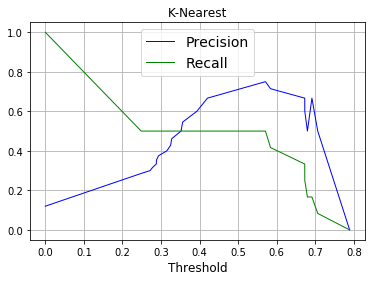

In [60]:
plt_precision_recall_vs_threshold(precision, recall, proba, title="K-Nearest")

In [61]:
y_train[ y_scores[:,1] >= 0.55 ]

CAUSEY RICHARD A      1
FASTOW ANDREW S       1
PAI LOU L             0
LAY KENNETH L         1
OLSON CINDY K         0
HIRKO JOSEPH          1
SKILLING JEFFREY K    1
RICE KENNETH D        1
Name: poi, dtype: uint8

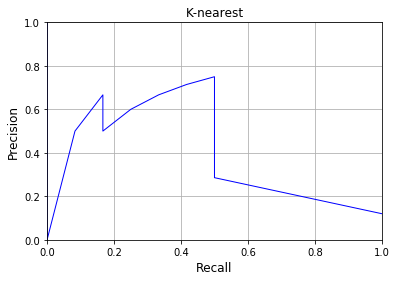

In [62]:
plt_precision_vs_recall(precision, recall, title="K-nearest")

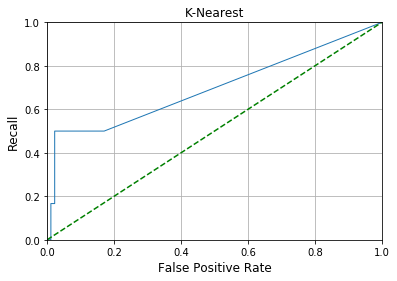

In [63]:
fpr, tpr, threshold = roc_curve( y_train, y_scores[:,1])
plot_roc_curve(fpr, tpr, title='K-Nearest')

In [64]:
X_train_44 = pipe_44.fit_transform(X_train)

In [65]:
RF_clf.fit(X_train_41, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=77, verbose=0, warm_start=False)

In [66]:
y_pred = cross_val_predict(RF_clf, X_train_41, y_train, cv=10)
confusion_matrix(y_train, y_pred)

array([[88,  0],
       [ 9,  3]], dtype=int64)

In [67]:
y_scores = cross_val_predict(RF_clf, X_train_41, y_train, cv=10, method='predict_proba' )

In [68]:
y_train[ y_scores[:,1] > 0.02 ].sum()

12

In [69]:
precision, recall, proba = precision_recall_curve(y_train, y_scores[:,1])

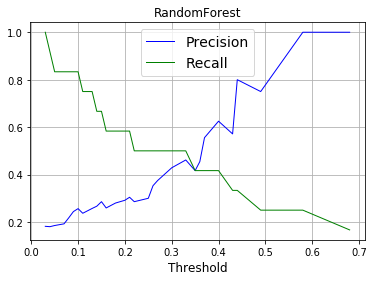

In [73]:
plt_precision_recall_vs_threshold(precision, recall, proba, title="RandomForest")

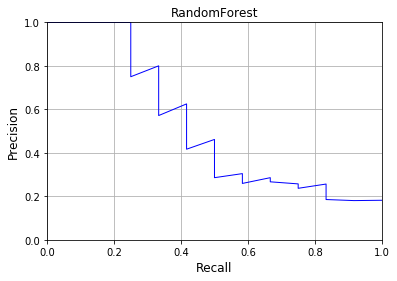

In [77]:
plt_precision_vs_recall(precision, recall, title='RandomForest')

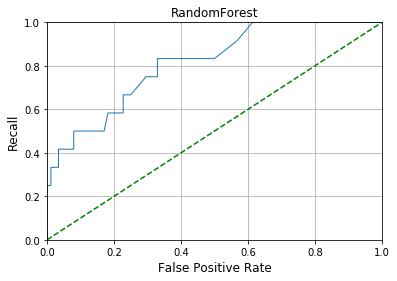

In [78]:
fpr, tpr, threshold = roc_curve( y_train, y_scores[:,1])
plot_roc_curve(fpr, tpr, title='RandomForest')

In [103]:
SGD_clf.fit(X_train_44, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=77, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [104]:
y_scores = cross_val_predict(SGD_clf, X_train_44, y_train, cv=10, method='decision_function' )

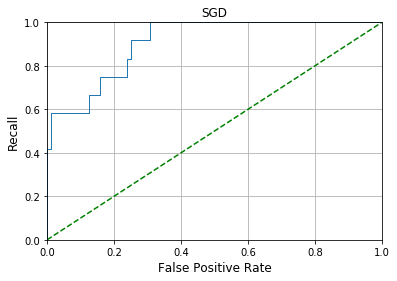

In [105]:
fpr, tpr, threshold = roc_curve( y_train, y_scores)
plot_roc_curve(fpr, tpr, title='SGD')

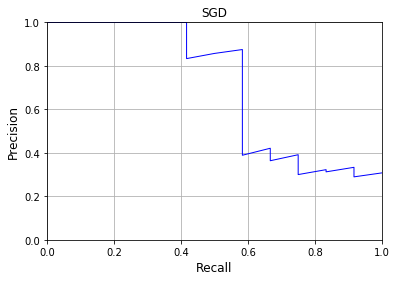

In [106]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title="SGD")

In [107]:
y_pred = cross_val_predict(SGD_clf, X_train_44, y_train, cv=10)
confusion_matrix(y_train, y_pred)

array([[81,  7],
       [ 5,  7]], dtype=int64)

In [126]:
y_pred_new = predict_from_score(y_train, y_scores, 0.75, 0.34, verbose=1 )

Realized metric values:
Recall: 0.75
Precision: 0.391304347826087
Probability/ decision function: -31.01907735376443
Index: 16


In [127]:
confusion_matrix(y_train, y_pred_new)

array([[74, 14],
       [ 3,  9]], dtype=int64)

In [85]:
svm_clf.fit(X_train_44, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
y_scores = cross_val_predict(svm_clf, X_train_44, y_train, cv=10, method='decision_function' )

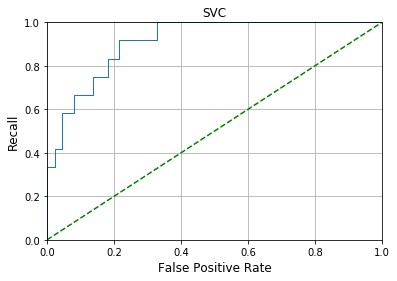

In [87]:
fpr, tpr, threshold = roc_curve( y_train, y_scores)
plot_roc_curve(fpr, tpr, title='SVC')

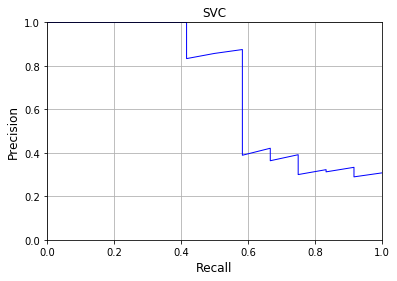

In [128]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC')

In [89]:
y_pred = cross_val_predict(svm_clf, X_train_44, y_train, cv=10)
confusion_matrix(y_train, y_pred)

array([[88,  0],
       [12,  0]], dtype=int64)

In [90]:
y_pred = predict_from_score(y_train, y_scores, 0.8, 0.3, verbose=0)

In [91]:
confusion_matrix(y_train, y_pred)

array([[69, 19],
       [ 1, 11]], dtype=int64)

In [130]:
AB_NB_clf.fit(X_train_44, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=GaussianNB(priors=None, var_smoothing=1e-09),
          learning_rate=1.0, n_estimators=50, random_state=77)

In [131]:
y_scores = cross_val_predict(AB_NB_clf, X_train_44, y_train, cv=10, method='decision_function' )

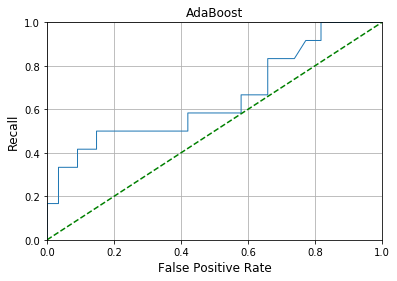

In [132]:
fpr, tpr, threshold = roc_curve( y_train, y_scores)
plot_roc_curve(fpr, tpr, title='AdaBoost')

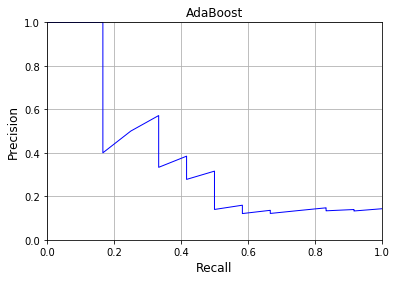

In [133]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='AdaBoost')

----

## Feature selection

In [136]:
svm_clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [137]:
y_scores = cross_val_predict(svm_clf, X_train_44, y_train, cv=10, method='decision_function' )

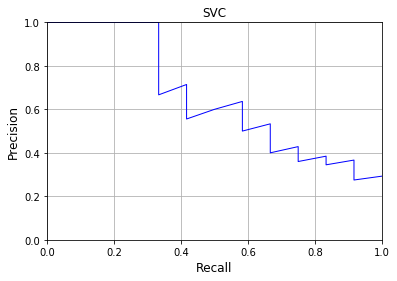

In [138]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC')

In [141]:
y_pred = predict_from_score(y_train, y_scores, 0.9, 0.3, verbose=1)

Realized metric values:
Recall: 0.9166666666666666
Precision: 0.36666666666666664
Probability/ decision function: -0.9314159592340644
Index: 11


In [142]:
confusion_matrix(y_train, y_pred)

array([[69, 19],
       [ 1, 11]], dtype=int64)

In [144]:
roc_auc_score(y_train, y_scores)

0.9119318181818181

In [151]:
X_train_44_df = pd.DataFrame(X_train_44, columns=feature_list)

In [203]:
y_scores = cross_val_predict(svm_clf, X_train_44_df.loc[:, payment_features+stock_features+extra_mail], y_train, cv=10, method='decision_function' )

In [204]:
roc_auc_score(y_train, y_scores)

0.9422348484848485

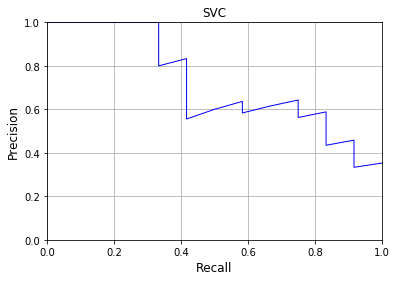

In [205]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC')

In [222]:
y_scores = cross_val_predict(SGD_clf, X_train_44_df.loc[:,feature_list], y_train, cv=10, method='decision_function' )

In [223]:
roc_auc_score(y_train, y_scores)

0.9081439393939393

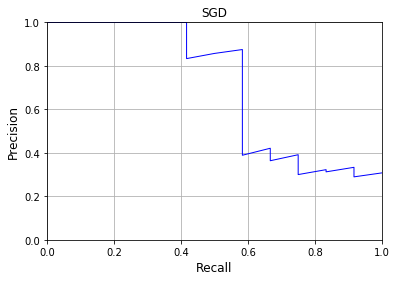

In [224]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SGD')

In [225]:
from sklearn.feature_selection import SelectFromModel

In [228]:
svm_clf.fit(X_train_44, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [234]:
svm_clf.coef_

AttributeError: coef_ is only available when using a linear kernel

In [229]:
model = SelectFromModel(svm_clf, prefit=True)

In [233]:
model.threshold_

AttributeError: 'SelectFromModel' object has no attribute 'estimator_'

In [ ]:
X_new = model.transform(X)
X_new.shape

----

In [54]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

In [55]:
# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

ImportError: No module named cross_validation

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)
'''